In [1]:
import lettuce as lt
from matplotlib import pyplot as plt
import time

In [58]:
#definiere "run" Funktion, die eine Simulation mit dreieckigem Hinderniss
#    durchführt.
#Simulationslänge ist von der y-Auflösung ny abhängig (ny*100 steps)
#
def run(ny=100, *axes):
    # ny: y-Auflösung, axes: Koordinatensystem(e), * erstellt ein Tupel aller übergebenen axes
    # ny=100 ist nur der default...
    
    lattice = lt.Lattice(lt.D2Q9, "cuda:0")
    flow = lt.Obstacle(
        (2*ny, ny), #shape der 2D-Box ist XxY: 2ny x ny
        reynolds_number=50.0,
        mach_number=0.05,
        lattice=lattice,
        domain_length_x=10.1, # in PU
    )
    x, y = flow.grid #gibt ein Meshgrid zurück: x-2D-Array, y-2D-Array
    print(x)
    print(y)
    
    condition = np.sqrt((x-2.5)**2+(y-2.5)**2) < 0.5 #die Kreisgleichung rechnet in PU, d.h. die Auflösung spielt hier keine Rolle(!)
    flow.mask[np.where(condition)] = 1 #erstelle Obstacle Form (mask als Bool)
    print("mask dim.:",flow.mask.shape)
    axes[0].imshow(flow.mask.T, origin="lower") #erstellt ein 2D-Bild der Maske
        #flow.mask.T ist die Transponierte von flow.mask (!)
        #der (0,0)-Punkt der Grafik sitzt unten links ("lower")
    
    tau = flow.units.relaxation_parameter_lu
    sim = lt.Simulation(flow, lattice, lt.BGKCollision(lattice, tau), 
                        lt.StandardStreaming(lattice))
    print("PU-Time: ",flow.units.convert_time_to_pu(ny*100)," seconds")
    
    t_start=time.time()
    n_steps=ny*100
    sim.step(n_steps) #Simulation mit Schrittzahl = 100*y-Auflösung
    print("number of steps:",n_steps)
    print("runtime: ",time.time()-t_start, "seconds")
    
    u = flow.units.convert_velocity_to_pu(lattice.u(sim.f).detach().cpu().numpy())
        #Geschwindigkeit wird als numpy-Array in den RAM geschrieben
    return axes[1].imshow(u[0,...].T, origin="lower")
        #erstellt ein 2D-Bild des Geschwindigkeitsfeldes

    print("Max Velocity: ", float(u.max()))
        #wird nicht ausgeführt, weil das schon hinter dem return ist...bruh

In [59]:
def run_and_plot(n):
    fig, axes = plt.subplots(1,2, figsize=(10,3)) #erstelle Figure
    fig.subplots_adjust(right=0.85) #Kürze figure-Größe rechts auf 85%
    im2 = run(n, *axes) #führe run() aus, übergebe die leeren Koordinatensysteme und die y-Auflösung
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7]) #fügt Koordinatensystem für colorbar hinzu
    fig.colorbar(im2, cax=cbar_ax) #fügt colorbar hinzu, zugehörig zum zweiten Koordinatensystem

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.202 0.202 0.202 ... 0.202 0.202 0.202]
 [0.404 0.404 0.404 ... 0.404 0.404 0.404]
 ...
 [9.494 9.494 9.494 ... 9.494 9.494 9.494]
 [9.696 9.696 9.696 ... 9.696 9.696 9.696]
 [9.898 9.898 9.898 ... 9.898 9.898 9.898]]
[[0.    0.202 0.404 ... 4.444 4.646 4.848]
 [0.    0.202 0.404 ... 4.444 4.646 4.848]
 [0.    0.202 0.404 ... 4.444 4.646 4.848]
 ...
 [0.    0.202 0.404 ... 4.444 4.646 4.848]
 [0.    0.202 0.404 ... 4.444 4.646 4.848]
 [0.    0.202 0.404 ... 4.444 4.646 4.848]]
mask dim.: (50, 25)
PU-Time:  14.578094297038053  seconds
number of steps: 2500
runtime:  2.6099143028259277 seconds


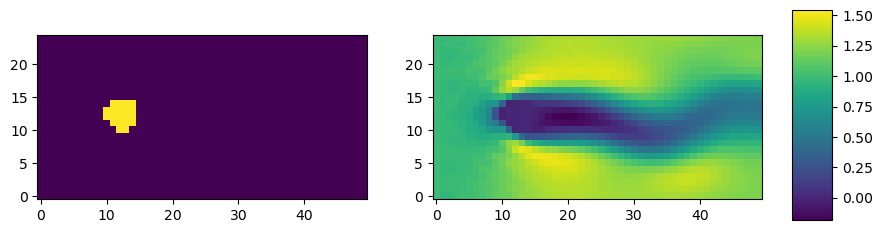

In [60]:
run_and_plot(25)

mask dim.: (100, 50)
PU-Time:  14.578094297038053  seconds
number of steps: 5000
runtime:  5.238961458206177 seconds


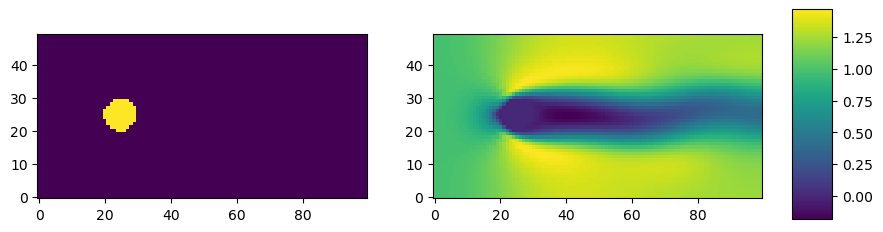

In [57]:
run_and_plot(50)

PU-Time:  14.578094297038053  seconds
number of steps: 10000
runtime:  10.466209173202515 seconds


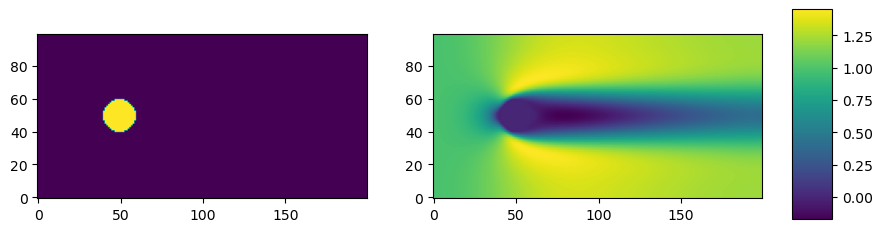

In [50]:
run_and_plot(100)